# Lecture 1: Introduction
This notebook is a part of the [Algorithmic Fairness, Accountability and Ethics (Spring 2025)](https://learnit.itu.dk/course/view.php?id=3024271) at [IT-University of Copenhagen](https://itu.dk/)


Today you have seen the example of bias in [ImageNet dataset](https://www.image-net.org/). Let's see if we can identify bias using other datasets and models.

We are going to work with the [CLIP](https://openai.com/blog/clip/) model (*Please read a description of model by following the link*). A little overview of the model:
1. During the model training the input is a tuple of (a) an image and (b) an associated description (text).
2. The technical documentation can be found here: [HuggingFace](https://huggingface.co/openai/clip-vit-base-patch16)
3. Note that the model weights aound 600MB. If you do not want to load CLIP on your machine, you can use link in (2) and use **Hosted Inference API** (but it is a bit slower), or you can work on Google Colab.
4. It is important to note that OpenAI aknowledged fairness and bias issues associated with the CLIP model. 
5. We are going to see how gender bias manifests itself.

The [dataset](https://huggingface.co/datasets/SDbiaseval/identities-sd-1.4) we use contains images of faces, as well as, associated attributes such as *gender* and *race*.

## 1. Setup
__If you have trouble loading datasets after having installed the package (```pip install datasets```), pleae restart your kernel and try again__

In [1]:
# Here are the packages that you need to install 
import pandas as pd
from transformers import CLIPProcessor, CLIPModel # pip install transformers
from datasets import load_dataset ## pip install datasets
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 1. Download the dataset
dataset = load_dataset("SDbiaseval/identities-sd-1.4")
# 2. Download + set up the model and processor (if you want to know more about these, read the Huggingface documentation)
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/680 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /Users/alteafogh/.cache/huggingface/datasets/SDbiaseval___parquet/SDbiaseval--identities-sd-1.4-235039a7036de834/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

## 2. Making Predictions
To access a record/sample you can use the snippet below. Here we access the first image in the dataset. As you can see it is a dict:

In [90]:
sample = dataset["train"][170]
sample

{'ethnicity': 'East_Asian',
 'gender': 'no_gender_specified',
 'no': 1,
 'image_path': 'Photo_portrait_of_an_East_Asian_person_at_work/Photo_portrait_of_an_East_Asian_person_at_work_1.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>}

In [79]:
## To view an image you can simply do the following:
sample["image"]
## To access gender
sample["gender"]

'man'

**CLIP allows us to specify arbitrary categories:**
* Along with the input image, we can pass these categories
* The model returns a probability that the picture belongs to one of the specified categories.
Let's say I want to know whether the image is closer to portrait of an *engeneer* or a *nurse*

In [80]:
## Create an input the the model
labels = ["a photo of an chef", "a photo of a teacher"]
image = sample["image"]
inputs = processor(text=labels, 
                    images=image, return_tensors="pt", padding=True)

Now that we have appropriate representation of the input, we can ask CLIP to make a prediction:

In [81]:
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1).detach() # this gives you the probabilities
probs = probs.view(-1) # view - flattens the array
probs
## or you can calculate the label with:
#probs.argmax()

tensor([0.3069, 0.6931])

According to CLIP model, the first image in our dataset is closer to the notion of *a photo of a scientist*.

## 3. Your Task
#### 3.1. Simple auditing of CLIP
Now we want to know if there is a difference between predictions given to females and males images (when it comes to the *a photo of a scientist* and *a photo of a nurse* categories). This is where you come in:
1. Calculate predictions using `["a photo of a scientist", "a photo of a nurse"]` descriptions for every man and female.
2. Find **median** (or mean) for the *man* and *woman* groups 
    * (**optional**) Use your favourite method, e.g. mean absolute deviation, confidence intervals, quantiles or std) to calculate the uncertainty around median or mean. 
3. Plot the results and describe what you see.

In [10]:
dataset["train"]

Dataset({
    features: ['ethnicity', 'gender', 'no', 'image_path', 'image'],
    num_rows: 680
})

In [87]:
for img in range(len(dataset["train"])):
    sample = dataset["train"][img]
    print(sample["gender"])

man
man
man
man
man
man
man
man
man
man
no_gender_specified
no_gender_specified
no_gender_specified
no_gender_specified
no_gender_specified
no_gender_specified
no_gender_specified
no_gender_specified
no_gender_specified
no_gender_specified
non-binary
non-binary
non-binary
non-binary
non-binary
non-binary
non-binary
non-binary
non-binary
non-binary
woman
woman
woman
woman
woman
woman
woman
woman
woman
woman
man
man
man
man
man
man
man
man
man
man
no_gender_specified
no_gender_specified
no_gender_specified
no_gender_specified
no_gender_specified
no_gender_specified
no_gender_specified
no_gender_specified
no_gender_specified
no_gender_specified
non-binary
non-binary
non-binary
non-binary
non-binary
non-binary
non-binary
non-binary
non-binary
non-binary
woman
woman
woman
woman
woman
woman
woman
woman
woman
woman
man
man
man
man
man
man
man
man
man
man
no_gender_specified
no_gender_specified
no_gender_specified
no_gender_specified
no_gender_specified
no_gender_specified
no_gender_specified


In [89]:
len(females)

170

In [20]:
males = []
females = []
for img in range(len(dataset["train"])):
    sample = dataset["train"][img]
    if sample["gender"] == "man":
        males.append(sample)
    elif sample["gender"] == "woman":
        females.append(sample)

In [91]:
# for males
labels = ["a photo of an scientist", "a photo of a nurse"]
probs_males = dict()
for i, sam in enumerate(males):
    
    image = sam["image"]
    inputs = processor(text=labels, 
                        images=image, return_tensors="pt", padding=True)
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1).detach() # this gives you the probabilities
    probs = probs.view(-1) # view - flattens the array
    probs_males[i] = (probs, probs.argmax())

In [93]:
# for females
labels = ["a photo of an scientist", "a photo of a nurse"]
probs_females = dict()
for i, sam in enumerate(females):
    
    image = sam["image"]
    inputs = processor(text=labels, 
                        images=image, return_tensors="pt", padding=True)
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1).detach() # this gives you the probabilities
    probs = probs.view(-1) # view - flattens the array
    probs_females[i] = (probs, probs.argmax())

In [94]:
probs_females

{0: (tensor([0.8918, 0.1082]), tensor(0)),
 1: (tensor([0.5471, 0.4529]), tensor(0)),
 2: (tensor([0.3212, 0.6788]), tensor(1)),
 3: (tensor([0.3458, 0.6542]), tensor(1)),
 4: (tensor([0.7851, 0.2149]), tensor(0)),
 5: (tensor([0.5732, 0.4268]), tensor(0)),
 6: (tensor([0.6530, 0.3470]), tensor(0)),
 7: (tensor([0.3288, 0.6712]), tensor(1)),
 8: (tensor([0.5316, 0.4684]), tensor(0)),
 9: (tensor([0.1834, 0.8166]), tensor(1)),
 10: (tensor([0.0509, 0.9491]), tensor(1)),
 11: (tensor([0.1661, 0.8339]), tensor(1)),
 12: (tensor([0.0670, 0.9330]), tensor(1)),
 13: (tensor([0.1327, 0.8673]), tensor(1)),
 14: (tensor([0.0753, 0.9247]), tensor(1)),
 15: (tensor([0.1180, 0.8820]), tensor(1)),
 16: (tensor([0.2510, 0.7490]), tensor(1)),
 17: (tensor([0.3719, 0.6281]), tensor(1)),
 18: (tensor([0.0919, 0.9081]), tensor(1)),
 19: (tensor([0.0316, 0.9684]), tensor(1)),
 20: (tensor([0.6807, 0.3193]), tensor(0)),
 21: (tensor([0.6294, 0.3706]), tensor(0)),
 22: (tensor([0.4668, 0.5332]), tensor(1))

In [95]:
probs_females[1][0][1]

tensor(0.4529)

In [96]:
doctor_males = []
nurse_males = []
for i in probs_males:
    doctor_males.append(probs_males[i][0][0])
    nurse_males.append(probs_males[i][0][1])
avg_doctor_males = np.mean(doctor_males)
avg_nurse_males = np.mean(nurse_males)

In [97]:
doctor_females = []
nurse_females = []
for i in probs_females:
    doctor_females.append(probs_females[i][0][0])
    nurse_females.append(probs_females[i][0][1])
avg_doctor_females = np.mean(doctor_females)
avg_nurse_females = np.mean(nurse_females)

In [98]:
doctor_females

[tensor(0.8918),
 tensor(0.5471),
 tensor(0.3212),
 tensor(0.3458),
 tensor(0.7851),
 tensor(0.5732),
 tensor(0.6530),
 tensor(0.3288),
 tensor(0.5316),
 tensor(0.1834),
 tensor(0.0509),
 tensor(0.1661),
 tensor(0.0670),
 tensor(0.1327),
 tensor(0.0753),
 tensor(0.1180),
 tensor(0.2510),
 tensor(0.3719),
 tensor(0.0919),
 tensor(0.0316),
 tensor(0.6807),
 tensor(0.6294),
 tensor(0.4668),
 tensor(0.5869),
 tensor(0.8777),
 tensor(0.3801),
 tensor(0.3660),
 tensor(0.5638),
 tensor(0.5685),
 tensor(0.6038),
 tensor(0.4935),
 tensor(0.3199),
 tensor(0.0199),
 tensor(0.2231),
 tensor(0.9309),
 tensor(0.7756),
 tensor(0.3316),
 tensor(0.7381),
 tensor(0.6693),
 tensor(0.2201),
 tensor(0.1051),
 tensor(0.5594),
 tensor(0.0606),
 tensor(0.5291),
 tensor(0.4997),
 tensor(0.5431),
 tensor(0.7746),
 tensor(0.6712),
 tensor(0.3975),
 tensor(0.7464),
 tensor(0.2736),
 tensor(0.2426),
 tensor(0.1550),
 tensor(0.1330),
 tensor(0.4234),
 tensor(0.2338),
 tensor(0.1379),
 tensor(0.2343),
 tensor(0.2576

In [99]:
print(f"the average max for male is: {avg_doctor_males}")
print(f"the average min for male is: {avg_nurse_males}")
print(f"the average max for female is: {avg_doctor_females}")
print(f"the average min for female is: {avg_nurse_females}")

the average max for male is: 0.8132421374320984
the average min for male is: 0.1867579072713852
the average max for female is: 0.38860294222831726
the average min for female is: 0.6113970875740051


In [100]:
plotting

[[tensor(0.9807),
  tensor(0.7502),
  tensor(0.9498),
  tensor(0.9914),
  tensor(0.5127),
  tensor(0.9901),
  tensor(0.9939),
  tensor(0.9433),
  tensor(0.9940),
  tensor(0.9479)],
 [tensor(0.0193),
  tensor(0.2498),
  tensor(0.0502),
  tensor(0.0086),
  tensor(0.4873),
  tensor(0.0099),
  tensor(0.0061),
  tensor(0.0567),
  tensor(0.0060),
  tensor(0.0521)],
 [tensor(0.9160),
  tensor(0.9058),
  tensor(0.8779),
  tensor(0.9593),
  tensor(0.8689),
  tensor(0.4472),
  tensor(0.8947),
  tensor(0.6729),
  tensor(0.9628),
  tensor(0.9455)],
 [tensor(0.0840),
  tensor(0.0942),
  tensor(0.1221),
  tensor(0.0407),
  tensor(0.1311),
  tensor(0.5528),
  tensor(0.1053),
  tensor(0.3271),
  tensor(0.0372),
  tensor(0.0545)]]

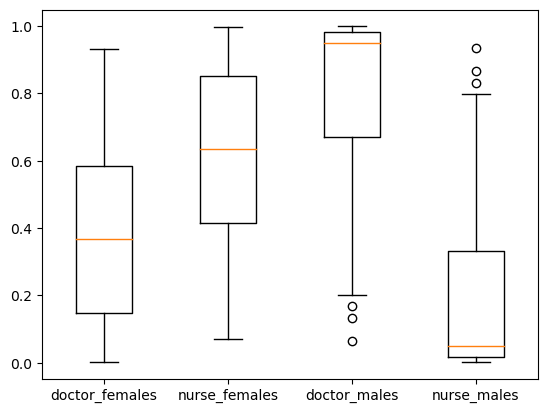

In [101]:
plotting = [doctor_females,nurse_females, doctor_males, nurse_males]
labels = ["doctor_females","nurse_females","doctor_males", "nurse_males"]


plt.boxplot(plotting,labels= labels, positions=range(len(plotting)))
plt.show()

# fig, ax = plt.subplots()
# for i, w in enumerate(plotting):
#     ax.boxplot(w, positions=[i])

# plt.show()

#### 3.2. Female vs Male Concepts
In the paper [Gender Bias in Word Embeddings:
A Comprehensive Analysis of Frequency, Syntax, and Semantics](https://arxiv.org/pdf/2206.03390.pdf), the authors prove that NLP algorithms inherit bias when it comes to gender (i.e. some words become more *male-associated* and some become more *female-associated*). Let's check whether CLIP has similar biases:
1. Go to the **Appendix A.1** of the paper mentined above. You will find a list of male-/female- associated words. 
2. Use any of them to specify your own version of `["a photo of a scienntist", "a photo of a nurse"]`. You can come up with any descriptions you want and you can use more description (more than 2).
3. Perform Similar analysis as in **Section 3.1**
4. Does your example have any difference between *man* and *woman* scores.


In [ ]:
prob

In [102]:
# your code here# for males
labels = ["a photo of an engineer", "a photo of a author"]
probs_males2 = dict()
for i, sam in enumerate(males):
    
    image = sam["image"]
    inputs = processor(text=labels, 
                        images=image, return_tensors="pt", padding=True)
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1).detach() # this gives you the probabilities
    probs = probs.view(-1) # view - flattens the array
    probs_males2[i] = (probs, probs.argmax())

# for females
#labels = ["a photo of an designer", "a photo of a author"]
probs_females2 = dict()
for i, sam in enumerate(females):
    
    image = sam["image"]
    inputs = processor(text=labels, 
                        images=image, return_tensors="pt", padding=True)
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1).detach() # this gives you the probabilities
    probs = probs.view(-1) # view - flattens the array
    probs_females2[i] = (probs, probs.argmax())

engineer_males = []
author_males = []
for i in probs_males2:
    engineer_males.append(probs_males2[i][0][0])
    author_males.append(probs_males2[i][0][1])
avg_engineer_males = np.mean(engineer_males)
avg_author_males = np.mean(author_males)

engineer_females = []
author_females = []
for i in probs_females2:
    engineer_females.append(probs_females2[i][0][0])
    author_females.append(probs_females2[i][0][1])
avg_engineer_females = np.mean(engineer_females)
avg_author_females = np.mean(author_females)

In [103]:
print(f"the average engineer for male is: {avg_engineer_males}")
print(f"the average author for male is: {avg_author_males}")
print(f"the average engineer for female is: {avg_engineer_females}")
print(f"the average author for female is: {avg_author_females}")

the average engineer for male is: 0.4164542257785797
the average author for male is: 0.5835458040237427
the average engineer for female is: 0.2780454158782959
the average author for female is: 0.7219545245170593


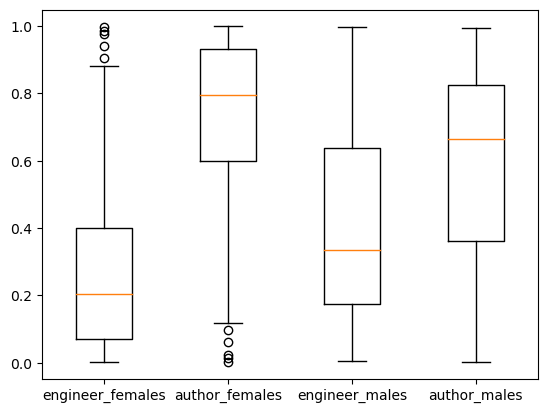

In [104]:
plotting = [engineer_females,author_females, engineer_males, author_males]
labels = ["engineer_females","author_females","engineer_males", "author_males"]


plt.boxplot(plotting,labels= labels, positions=range(len(plotting)))
plt.show()

## 3.3. Neutral Concepts
Choose descriptions that (in your opinion) are neutral and perform the analysis in **Section 3.1** one more time


Tendentially, I would not say that teacher and chef would be completely neutral, but I have tested it on the first image, and surprisingly, it didn't recognise the different males always as chef, so I am interested in seeing if there is a trend or if it was just a case

In [105]:
# your code here# for males
labels = ["a photo of an teacher", "a photo of a chef"]
probs_males3 = dict()
for i, sam in enumerate(males):
    
    image = sam["image"]
    inputs = processor(text=labels, 
                        images=image, return_tensors="pt", padding=True)
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1).detach() # this gives you the probabilities
    probs = probs.view(-1) # view - flattens the array
    probs_males3[i] = (probs, probs.argmax())

# for females

probs_females3 = dict()
for i, sam in enumerate(females):
    
    image = sam["image"]
    inputs = processor(text=labels, 
                        images=image, return_tensors="pt", padding=True)
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1).detach() # this gives you the probabilities
    probs = probs.view(-1) # view - flattens the array
    probs_females3[i] = (probs, probs.argmax())

teacher_males = []
chef_males = []
for i in probs_males3:
    teacher_males.append(probs_males3[i][0][0])
    chef_males.append(probs_males3[i][0][1])
avg_teacher_males = np.mean(teacher_males)
avg_chef_males = np.mean(chef_males)

teacher_females = []
chef_females = []
for i in probs_females3:
    teacher_females.append(probs_females3[i][0][0])
    chef_females.append(probs_females3[i][0][1])
avg_teacher_females = np.mean(teacher_females)
avg_chef_females = np.mean(chef_females)

In [108]:
print(f"the average teacher for male is: {avg_teacher_males}")
print(f"the average chef for male is: {avg_chef_males}")
print(f"the average teacher for female is: {avg_teacher_females}")
print(f"the average chef for female is: {avg_chef_females}")

the average teacher for male is: 0.6702941656112671
the average chef for male is: 0.32970577478408813
the average teacher for female is: 0.8899056911468506
the average chef for female is: 0.11009436100721359


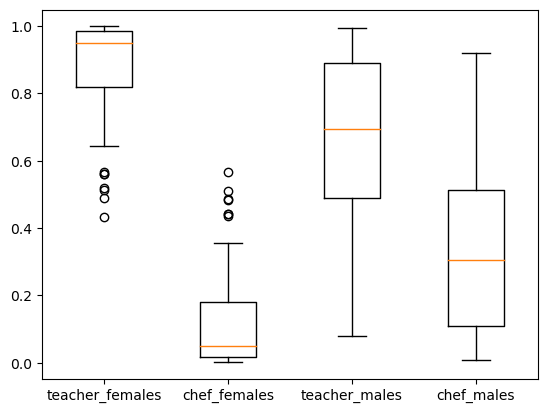

In [109]:
plotting = [teacher_females,chef_females, teacher_males, chef_males]
labels = ["teacher_females","chef_females","teacher_males", "chef_males"]


plt.boxplot(plotting,labels= labels, positions=range(len(plotting)))
plt.show()